In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jay7080dev/rice-plant-diseases-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'rice-plant-diseases-dataset' dataset.
Path to dataset files: /kaggle/input/rice-plant-diseases-dataset


In [2]:
from pathlib import Path

root = Path(path)   # path = "/root/.cache/kagglehub/datasets/noulam/tomato/versions/1"

print("Dataset root:", root)
!ls -R {root}


Dataset root: /kaggle/input/rice-plant-diseases-dataset
/kaggle/input/rice-plant-diseases-dataset:
'rice leaf diseases dataset'

'/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset':
Bacterialblight  Brownspot  Leafsmut

'/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Bacterialblight':
 BACTERAILBLIGHT3_001.jpg	 BACTERAILBLIGHT5_255.jpg
 BACTERAILBLIGHT3_002.jpg	 BACTERAILBLIGHT5_256.jpg
 BACTERAILBLIGHT3_003.jpg	 BACTERAILBLIGHT5_257.jpg
 BACTERAILBLIGHT3_004.jpg	 BACTERAILBLIGHT5_258.jpg
 BACTERAILBLIGHT3_005.jpg	 BACTERAILBLIGHT5_259.jpg
 BACTERAILBLIGHT3_006.jpg	 BACTERAILBLIGHT5_260.jpg
 BACTERAILBLIGHT3_007.jpg	 BACTERAILBLIGHT5_261.jpg
 BACTERAILBLIGHT3_008.jpg	 BACTERAILBLIGHT5_262.jpg
 BACTERAILBLIGHT3_009.jpg	 BACTERAILBLIGHT5_263.jpg
 BACTERAILBLIGHT3_010.jpg	 BACTERAILBLIGHT5_264.jpg
 BACTERAILBLIGHT3_011.jpg	 BACTERIALBLIGHT_001.jpg
 BACTERAILBLIGHT3_012.jpg	 BACTERIALBLIGHT_002.jpg
 BACTERAILBLIGHT3_013.jpg	 BACTERIALBLIGHT_003.jpg


In [3]:
import pandas as np
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
print(torch.__version__)
print(torchvision.__version__)

2.9.0+cu126
0.24.0+cu126


In [5]:
from pathlib import Path

root = Path(path)
dataset_root = root / "rice leaf diseases dataset"
print("Dataset root:", dataset_root)



Dataset root: /kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset


In [6]:
all_images = []
extensions = ["*.jpg", "*.JPG", "*.png", "*.PNG"]

for cls in dataset_root.iterdir():
    if cls.is_dir():
        for ext in extensions:
            all_images.extend(list(cls.glob(ext)))

print("Total images found:", len(all_images))
print(all_images[:5])

Total images found: 4684
[PosixPath('/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Bacterialblight/BACTERIALBLIGHT_094.jpg'), PosixPath('/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Bacterialblight/BACTERIALBLIGHT1_116.jpg'), PosixPath('/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Bacterialblight/BACTERIALBLIGHT1_163.jpg'), PosixPath('/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT5_100.jpg'), PosixPath('/kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Bacterialblight/BACTERAILBLIGHT3_116.jpg')]


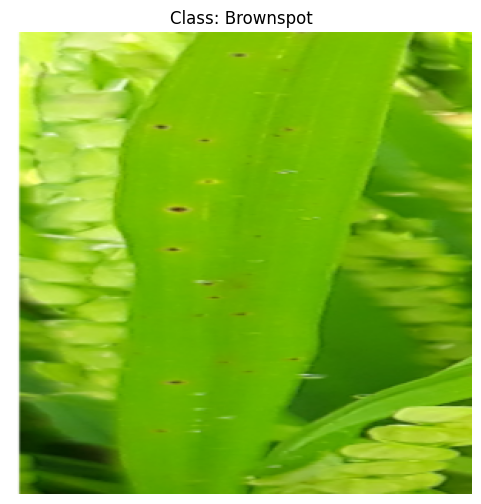

Random image path: /kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset/Brownspot/BROWNSPOT6_004.jpg
Image class: Brownspot


In [7]:
import random
from PIL import Image
import matplotlib.pyplot as plt


assert len(all_images) > 0


random_image_path = random.choice(all_images)


image_class_name = random_image_path.parent.stem


opened_image = Image.open(random_image_path).convert("RGB")


plt.figure(figsize=(6, 6))
plt.imshow(opened_image)
plt.title(f"Class: {image_class_name}")
plt.axis("off")
plt.show()

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class_name}")


(np.float64(-0.5), np.float64(299.5), np.float64(299.5), np.float64(-0.5))

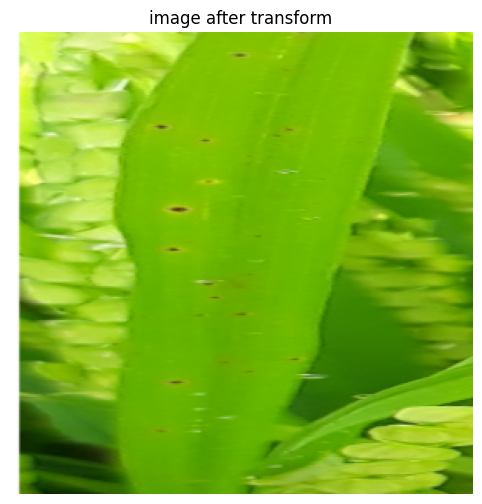

In [8]:
#turn the image into array
img_as_array = np.array(opened_image)
#plot the image
plt.figure(figsize=(12,6))
plt.imshow(img_as_array)
plt.xlabel(image_class_name)
plt.title("image after transform")
plt.axis(False)

In [9]:
image_data_train_transform = transforms.Compose([
    #resize our image to 224,224
    transforms.RandomResizedCrop(size=(224,224),scale=(0.8,1.0)),#zoom in ramdomly
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),#add vertical flip with a low probability
    transforms.RandomRotation(degrees=30),
    #turn the data into a torch.tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)) # random erase parts of the image to make it harder
])
image_data_test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Dataset root: /kaggle/input/rice-plant-diseases-dataset/rice leaf diseases dataset


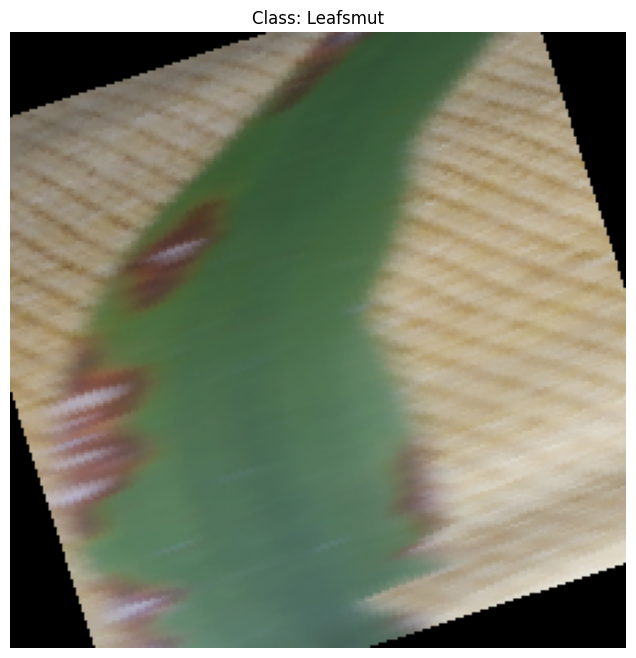

In [10]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

# === 1. Correct dataset path ===
dataset_root = Path(path) / "rice leaf diseases dataset"
print("Dataset root:", dataset_root)

# === 2. Use your transformations ===
train_data = datasets.ImageFolder(
    root=dataset_root,
    transform=image_data_train_transform
)

test_data = datasets.ImageFolder(
    root=dataset_root,
    transform=image_data_test_transform
)

# === 3. DataLoader settings ===
batch_size = 64
num_workers = 0

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# === 4. Get a batch ===
images, labels = next(iter(train_dataloader))
img_tensor = images[0]

# === 5. Un-normalize parameters (ImageNet mean/std) ===
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# === 6. Unnormalize function ===
def unnormalize(img_tensor, mean, std):
    img_tensor = img_tensor.clone()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

# === 7. Prepare image for plotting ===
img_unnormalized = unnormalize(img_tensor, mean, std)
img_to_plot = img_unnormalized.permute(1, 2, 0).numpy().clip(0, 1)

# === 8. Plot ===
plt.figure(figsize=(8,8))
plt.imshow(img_to_plot)
plt.title(f"Class: {train_data.classes[labels[0]]}")
plt.axis("off")
plt.show()


In [11]:
from pathlib import Path

root = Path("/root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1")
dataset_root = root / "rice leaf diseases dataset"

all_images = []
extensions = ["*.jpg", "*.JPG", "*.jpeg", "*.JPEG", "*.png", "*.PNG"]

for class_folder in dataset_root.iterdir():
    if class_folder.is_dir():
        for ext in extensions:
            all_images.extend(list(class_folder.glob(ext)))

print("Total images found:", len(all_images))
print("Example:", all_images[:5])



Total images found: 4684
Example: [PosixPath('/root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1/rice leaf diseases dataset/Brownspot/BROWNSPOT6_159.jpg'), PosixPath('/root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1/rice leaf diseases dataset/Brownspot/BROWNSPOT7_168.jpg'), PosixPath('/root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1/rice leaf diseases dataset/Brownspot/BROWNSPOT1_067.jpg'), PosixPath('/root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1/rice leaf diseases dataset/Brownspot/brownspot_rotated_093.jpg'), PosixPath('/root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1/rice leaf diseases dataset/Brownspot/brownspot_orig_036.jpg')]


In [12]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

def plot_transformed_image(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)

    sample_paths = random.sample(image_paths, k=n)

    for image_path in sample_paths:

        img = Image.open(image_path).convert("RGB")

        fig, ax = plt.subplots(1, 2, figsize=(10, 5))


        ax[0].imshow(img)
        ax[0].set_title("Original")
        ax[0].axis("off")


        transformed = transform(img)

        if isinstance(transformed, torch.Tensor):
            transformed = transformed.permute(1, 2, 0).cpu().numpy()

        transformed = np.clip(transformed, 0, 1)

        ax[1].imshow(transformed)
        ax[1].set_title("Transformed")
        ax[1].axis("off")

        plt.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)
        plt.show()


In [13]:
print(len(all_images))


4684


In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path

# Rice dataset root
root = Path("/root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1")
dataset_root = root / "rice leaf diseases dataset"

print("Dataset root:", dataset_root)

# === Create Dataset ===
full_dataset = datasets.ImageFolder(
    root=dataset_root,
    transform=image_data_train_transform
)

print("Total Images:", len(full_dataset))
print("Classes:", full_dataset.classes)



Dataset root: /root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1/rice leaf diseases dataset
Total Images: 4684
Classes: ['Bacterialblight', 'Brownspot', 'Leafsmut']


In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# ==== 1. Load full dataset ====
full_dataset = datasets.ImageFolder(
    root=dataset_root,
    transform=image_data_train_transform
)

# ==== 2. Split indices ====
indices = list(range(len(full_dataset)))
train_idx, valid_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

train_dataset = Subset(full_dataset, train_idx)
valid_dataset = Subset(full_dataset, valid_idx)

# valid dataset 应该用 test_transform
valid_dataset.dataset.transform = image_data_test_transform

# ==== 3. Dataloaders ====
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader  = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=0)

print("Train Images:", len(train_dataset))
print("Valid/Test Images:", len(valid_dataset))
print("Classes:", full_dataset.classes)

Train Images: 3747
Valid/Test Images: 937
Classes: ['Bacterialblight', 'Brownspot', 'Leafsmut']


In [16]:
len(train_dataset), len(valid_dataset)


(3747, 937)

In [17]:
img, label = train_dataset[0][0], valid_dataset[0][1]
print(f"image tensor:\n {img}")
print(f"image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"image label: {label}")
print(f"label datatype: {type(label)}")

image tensor:
 tensor([[[-0.4739, -0.4739, -0.4911,  ...,  0.9303,  0.9132,  0.9132],
         [-0.4739, -0.4739, -0.4739,  ...,  0.9646,  0.9303,  0.8961],
         [-0.4568, -0.4739, -0.4739,  ...,  0.9988,  0.9474,  0.8618],
         ...,
         [ 0.5878,  0.6221,  0.6563,  ...,  0.3823,  0.4679,  0.5364],
         [ 0.5878,  0.6221,  0.6563,  ...,  0.3138,  0.4166,  0.5022],
         [ 0.5878,  0.6221,  0.6563,  ...,  0.2624,  0.3652,  0.4508]],

        [[ 0.3803,  0.3803,  0.3627,  ...,  1.1155,  1.0980,  1.0980],
         [ 0.3803,  0.3803,  0.3803,  ...,  1.1506,  1.1155,  1.0805],
         [ 0.3978,  0.3803,  0.3803,  ...,  1.1856,  1.1331,  1.0455],
         ...,
         [ 0.7304,  0.7654,  0.8004,  ...,  1.3081,  1.3957,  1.4657],
         [ 0.7304,  0.7654,  0.8004,  ...,  1.2381,  1.3431,  1.4307],
         [ 0.7304,  0.7654,  0.8004,  ...,  1.1856,  1.2906,  1.3782]],

        [[-1.1073, -1.1073, -1.1247,  ...,  1.3154,  1.2980,  1.2980],
         [-1.1073, -1.1073, -1

In [18]:
import torch
import matplotlib.pyplot as plt

def imshow_tensor(img_tensor):
    """
    Un-normalize & display a tensor image.
    Works with RICE DATASET since we use ImageNet normalization.
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    img = img_tensor.clone()
    img = img * std + mean     # unnormalize
    img = img.permute(1,2,0)   # CHW → HWC
    img = torch.clamp(img, 0, 1)

    plt.imshow(img.numpy())
    plt.axis("off")


In [19]:
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
from pathlib import Path
import numpy as np
import torch

# === 1. Load RICE DATASET ===
root = Path("/root/.cache/kagglehub/datasets/jay7080dev/rice-plant-diseases-dataset/versions/1")
dataset_root = root / "rice leaf diseases dataset"

full_dataset = datasets.ImageFolder(
    root=dataset_root,
    transform=image_data_train_transform   # train transform for now
)

total_size = len(full_dataset)
print(f"Total images in full_dataset: {total_size}")

# === 2. Split 70 / 15 / 15 ===
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

print(f"Training size:   {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size:       {test_size}")

# === 3. Shuffle indices ===
indices = list(range(total_size))
np.random.seed(42)
np.random.shuffle(indices)

train_idx = indices[:train_size]
val_idx   = indices[train_size : train_size + val_size]
test_idx  = indices[train_size + val_size :]

# === 4. Create Subsets (Rice version) ===
train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

# Validation/Test 应使用 test_transform
val_dataset.dataset.transform  = image_data_test_transform
test_dataset.dataset.transform = image_data_test_transform

print("Split finished without leakage.")

# === 5. Dataloaders ===
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0, pin_memory=True)

val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=0, pin_memory=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=0, pin_memory=True)

print("Train batches:", len(train_dataloader))
print("Val batches:", len(val_dataloader))
print("Test batches:", len(test_dataloader))

print("Classes:", full_dataset.classes)


Total images in full_dataset: 4684
Training size:   3278
Validation size: 702
Test size:       704
Split finished without leakage.
Train batches: 205
Val batches: 44
Test batches: 44
Classes: ['Bacterialblight', 'Brownspot', 'Leafsmut']


In [20]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

def improve_resnet_model(num_classes: int):
    """
    Creates a ResNet-50 model with a frozen base and a custom classifier head.

    Args:
        num_classes (int): The number of output classes for the model.
    """
    #load a pre-trained resnet50 model
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    #freeze the base model parameters
    for param in model.parameters():
        param.requires_grad = False

    #Get the number of input features from the original fully connected layer
    num_ftrs = model.fc.in_features

    #Replace the final layer with a new, more powerful classifier head (Improved)
    model.fc = nn.Sequential( # Use nn.Sequential for multiple layers
        nn.Linear(num_ftrs, 512),   # Add an intermediate layer
        nn.ReLU(),                 # Add a non-linear activation
        nn.Dropout(p=0.5),         # Add dropout for regularization
        nn.Linear(512, num_classes) # The final output layer
    )
    return model

In [21]:
#create instance of tinyvgg
torch.manual_seed(42)
# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
# insatantial the model
model = improve_resnet_model(num_classes=len(train_data.classes)).to(device)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
#Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape
#batch size will now be 1, you can change the batch size if you like
print(f"image shape: {image_batch.shape} -> [batch_size, color_channels, height, width]")
print(f"label shape: {label_batch.shape}")

image shape: torch.Size([16, 3, 224, 224]) -> [batch_size, color_channels, height, width]
label shape: torch.Size([16])


In [23]:
#try a forward pass
model(image_batch.to(device))

tensor([[-0.0092,  0.1133, -0.0193],
        [ 0.0435,  0.1704,  0.0409],
        [ 0.0577,  0.0417, -0.0837],
        [ 0.0086, -0.0198,  0.0547],
        [ 0.0539,  0.0310, -0.0123],
        [-0.0064, -0.0149,  0.0104],
        [ 0.0699,  0.0309, -0.0340],
        [ 0.0279, -0.0646, -0.1146],
        [ 0.1089, -0.0118, -0.0090],
        [ 0.0648,  0.0037,  0.0113],
        [-0.0501, -0.0099, -0.0008],
        [ 0.0918, -0.0583, -0.0650],
        [ 0.0200,  0.0060, -0.0454],
        [ 0.0364,  0.1217, -0.0131],
        [ 0.0683,  0.0900, -0.0291],
        [ 0.0394, -0.0136,  0.0965]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [24]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model, input_size=[32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 3]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [25]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device):

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Forward
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        y_pred_class = y_pred.argmax(dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    # Average per batch
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss, train_acc


In [26]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device):

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_labels = y_pred.argmax(dim=1)
            test_acc += (y_pred_labels == y).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc


In [27]:
from tqdm.auto import tqdm
import torch

def train_final(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,   # <-- val_dataloader for rice
                optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler._LRScheduler,
                loss_fn: torch.nn.Module,
                epochs: int,
                device: torch.device,
                patience: int = 5):

    print(">>> Starting training with early stopping and scheduler...")

    best_val_loss = float("inf")
    epochs_no_improve = 0
    best_model_path = "best_model.pth"

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for epoch in tqdm(range(epochs)):

        # ---- Training ----
        train_loss, train_acc = train_step(
            model, train_dataloader, loss_fn, optimizer, device
        )

        # ---- Validation ----
        val_loss, val_acc = test_step(
            model, test_dataloader, loss_fn, device
        )

        # ---- Scheduler ----
        scheduler.step(val_loss)

        # ---- Logging ----
        print(f"\nEpoch {epoch+1}/{epochs}"
              f" | Train Acc: {train_acc:.4f}"
              f" | Val Acc: {val_acc:.4f}"
              f" | Val Loss: {val_loss:.4f}")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # ---- Early Stopping ----
        if val_loss < best_val_loss:
            print(f"✅ Improved Val Loss: {best_val_loss:.4f} → {val_loss:.4f}. Saving model...")
            torch.save(model.state_dict(), best_model_path)
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement ({epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print("⏹ Early stopping triggered!")
            break

    # ---- Load best model ----
    model.load_state_dict(torch.load(best_model_path))
    print("🏆 Training complete. Best model loaded.")

    return model, history


In [28]:
import torch.nn as nn
import torch.optim as optim

# Loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)


In [29]:
model, history = train_final(
    model,
    train_dataloader=train_dataloader,   # rice 70%
    test_dataloader=val_dataloader,      # rice 15%
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
    patience=5
)


>>> Starting training with early stopping and scheduler...


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10 | Train Acc: 0.7771 | Val Acc: 0.9103 | Val Loss: 0.3709
✅ Improved Val Loss: inf → 0.3709. Saving model...

Epoch 2/10 | Train Acc: 0.9084 | Val Acc: 0.9545 | Val Loss: 0.1919
✅ Improved Val Loss: 0.3709 → 0.1919. Saving model...

Epoch 3/10 | Train Acc: 0.9460 | Val Acc: 0.9787 | Val Loss: 0.1293
✅ Improved Val Loss: 0.1919 → 0.1293. Saving model...

Epoch 4/10 | Train Acc: 0.9643 | Val Acc: 0.9886 | Val Loss: 0.0824
✅ Improved Val Loss: 0.1293 → 0.0824. Saving model...

Epoch 5/10 | Train Acc: 0.9698 | Val Acc: 0.9929 | Val Loss: 0.0595
✅ Improved Val Loss: 0.0824 → 0.0595. Saving model...

Epoch 6/10 | Train Acc: 0.9783 | Val Acc: 0.9943 | Val Loss: 0.0533
✅ Improved Val Loss: 0.0595 → 0.0533. Saving model...

Epoch 7/10 | Train Acc: 0.9829 | Val Acc: 0.9972 | Val Loss: 0.0388
✅ Improved Val Loss: 0.0533 → 0.0388. Saving model...

Epoch 8/10 | Train Acc: 0.9860 | Val Acc: 0.9972 | Val Loss: 0.0296
✅ Improved Val Loss: 0.0388 → 0.0296. Saving model...

Epoch 9/10 | Train

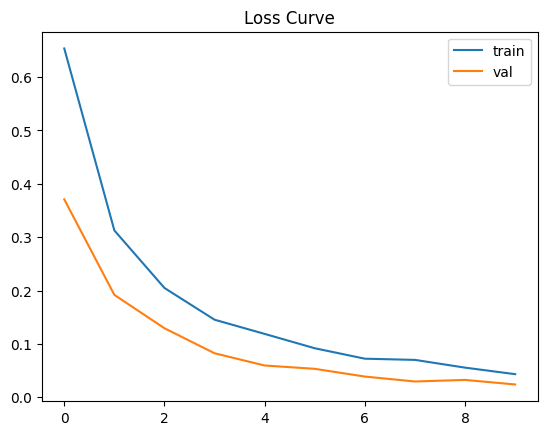

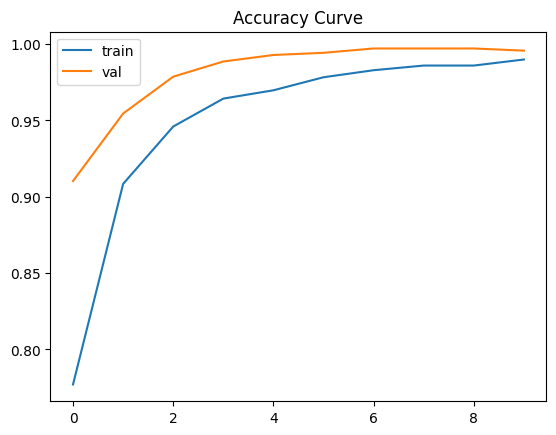

In [30]:
import matplotlib.pyplot as plt

plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.legend(["train", "val"])
plt.title("Loss Curve")
plt.show()

plt.plot(history["train_acc"])
plt.plot(history["val_acc"])
plt.legend(["train", "val"])
plt.title("Accuracy Curve")
plt.show()


In [34]:
import torch

def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


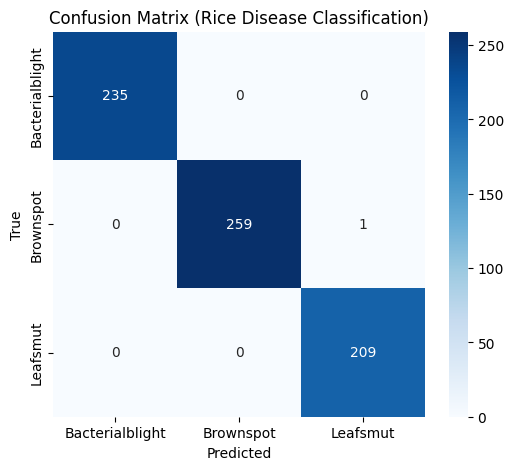

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels, preds = get_all_preds(model, test_dataloader, device)

cm = confusion_matrix(labels, preds)
class_names = full_dataset.classes   # ['Bacterialblight', 'Brownspot', 'Leafsmut']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix (Rice Disease Classification)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [36]:
accuracy = (preds == labels).mean()
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 99.86%


In [37]:
for i, cls in enumerate(class_names):
    cls_idx = np.where(labels == i)[0]
    cls_acc = (preds[cls_idx] == i).mean()
    print(f"{cls}: {cls_acc*100:.2f}%")


Bacterialblight: 100.00%
Brownspot: 99.62%
Leafsmut: 100.00%


In [38]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds, target_names=class_names))


                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       235
      Brownspot       1.00      1.00      1.00       260
       Leafsmut       1.00      1.00      1.00       209

       accuracy                           1.00       704
      macro avg       1.00      1.00      1.00       704
   weighted avg       1.00      1.00      1.00       704

